# Fire/Smoke detection
### Spatial Model Scoping
#### Emily Donofrio

Citation for data source: <br>
Wang, M., Yue, P., Jiang, L., Yu, D., Tuo, T., & Li, J. (2025). An open flame and smoke detection dataset for deep learning in remote sensing based fire detection. Geo-spatial Information Science, 28(2), 511-526. <br>
<br>
Link: https://www.scidb.cn/en/detail?dataSetId=ce9c9400b44148e1b0a749f5c3eb0bda

In [8]:
import keras
import os
import pandas as pd
from xml.etree import ElementTree as ET

In [ ]:
image_folder = 'images'

In [4]:
print( f"images: {len(os.listdir(image_folder))}")

images: 95314


### Add labels from annotations

In [9]:
# Load VOC annotations and create image-level labeled dataset
annotation_folder = 'annotations/VOC_CV/Annotations/'
xml_files = [f for f in os.listdir(annotation_folder) if f.endswith('.xml')]

rows = []
for xml_file in xml_files:
    tree = ET.parse(os.path.join(annotation_folder, xml_file))
    root = tree.getroot()
    filename = root.find('filename').text
    width = int(root.find('size/width').text)
    height = int(root.find('size/height').text)
    names = set()
    for obj in root.findall('object'):
        name = obj.find('name').text
        names.add(name)
    
    if 'fire' in names and 'smoke' in names:
        cls = 'both'
    elif 'fire' in names:
        cls = 'fire'
    elif 'smoke' in names:
        cls = 'smoke'
    else:
        cls = 'neither'
    
    rows.append({
        'image_path': f'images/{filename}',
        'width': width,
        'height': height,
        'class': cls
    })

# Create DataFrame
df = pd.DataFrame(rows)
print(f"Dataset shape: {df.shape}")
print(df['class'].value_counts())
print(df.head())

Dataset shape: (95314, 4)
class
neither    39199
smoke      23414
both       20151
fire       12550
Name: count, dtype: int64
                                image_path  width  height    class
0  images/neitherFireNorSmoke_CV037726.jpg    600     600  neither
1     images/bothFireAndSmoke_CV011689.jpg    224     224     both
2  images/neitherFireNorSmoke_CV009810.jpg    512     384  neither
3                images/smoke_CV018663.jpg   1920    1080    smoke
4                images/smoke_CV017550.jpg   1920    1080    smoke


### Preview images

Image path: images/smoke_CV009718.jpg, Class: smoke
Image path: images/neitherFireNorSmoke_CV015238.jpg, Class: neither
Image path: images/fire_CV006365.jpg, Class: fire
Image path: images/fire_CV010359.jpg, Class: fire
Image path: images/smoke_CV022313.jpg, Class: smoke


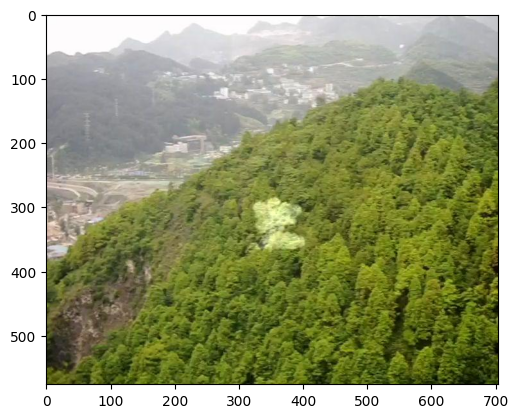

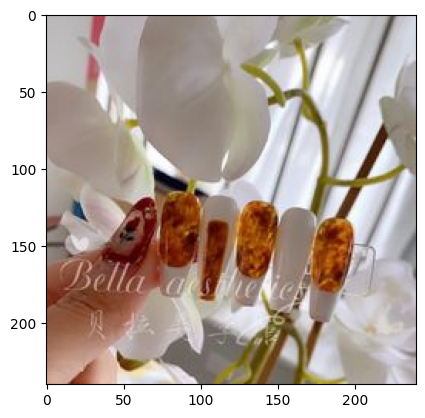

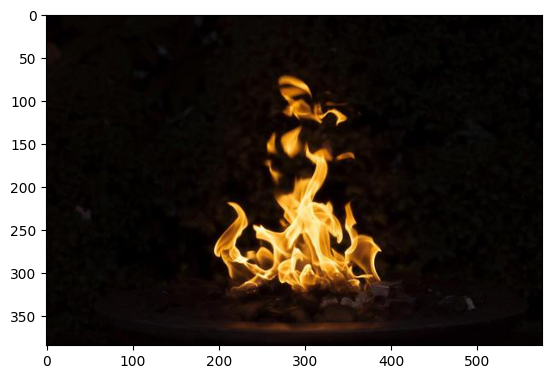

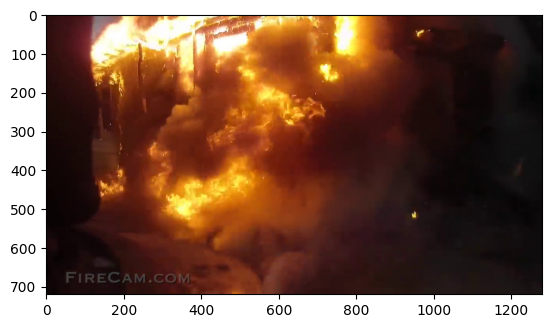

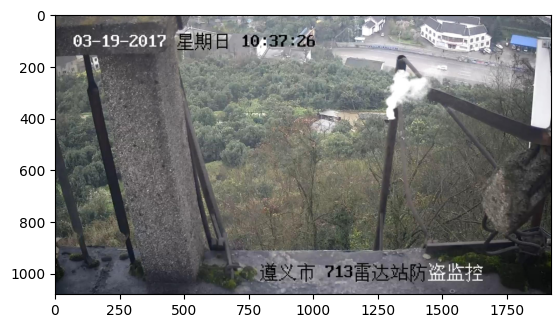

In [ ]:
# Look at random images and their labels
import matplotlib.pyplot as plt
import matplotlib.patches as patches

for i in range(5):
    sample_row = df.sample(1).iloc[0]
    image = plt.imread(sample_row['image_path'])
    fig, ax = plt.subplots(1)
    ax.imshow(image)
    print(f"Image path: {sample_row['image_path']}, Class: {sample_row['class']}")

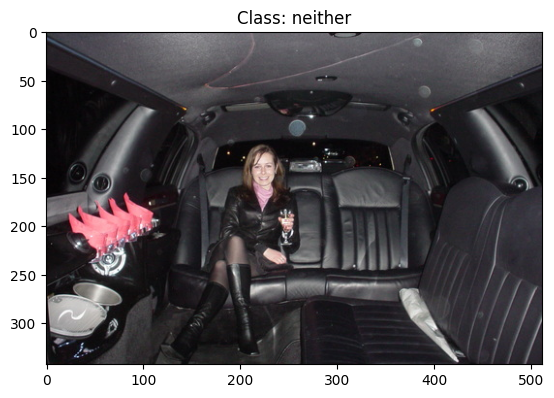

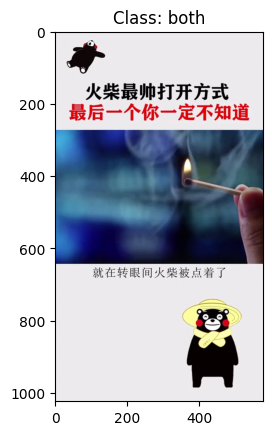

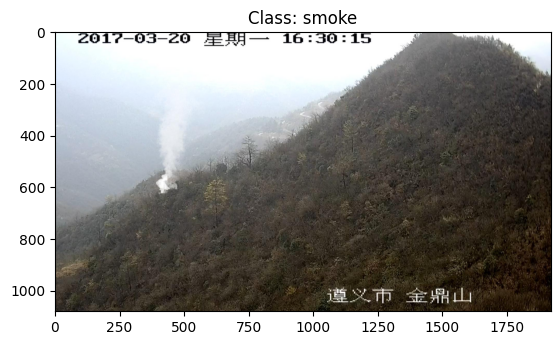

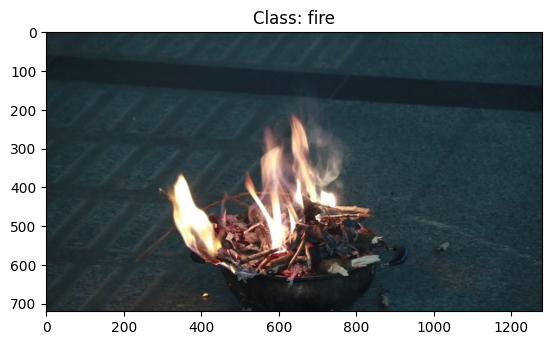

In [21]:
# look at an image from each class
classes = df['class'].unique()
for cls in classes:
    sample_row = df[df['class'] == cls].sample(1).iloc[0]
    image = plt.imread(sample_row['image_path'])
    fig, ax = plt.subplots(1)
    ax.imshow(image)
    plt.title(f"Class: {cls}")
    plt.show()

### Create image related attributes

In [14]:
# create aspect ratio
df['aspect_ratio'] = df['width'] / df['height']

print(df['aspect_ratio'].describe())

count    95314.000000
mean         1.401499
std          0.402475
min          0.151630
25%          1.000000
50%          1.499481
75%          1.777778
max          5.603448
Name: aspect_ratio, dtype: float64


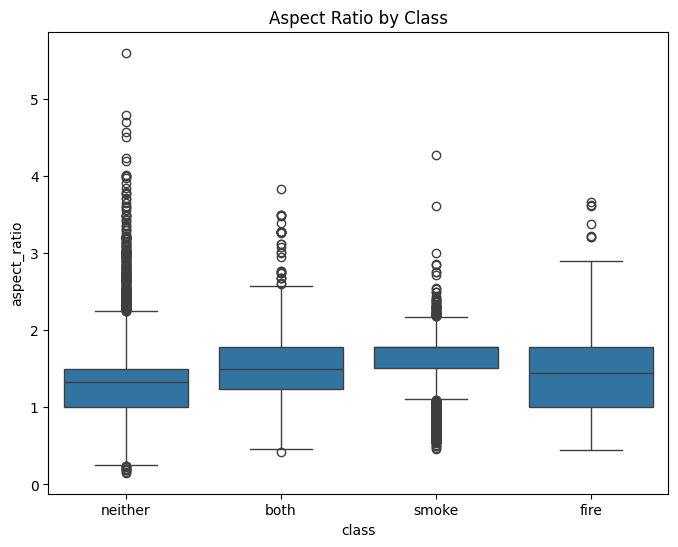

In [16]:
# boxplot of aspect ratios by class
import seaborn as sns
plt.figure(figsize=(8,6))
sns.boxplot(x='class', y='aspect_ratio', data=df)
plt.title('Aspect Ratio by Class')
plt.show()

In [17]:
# create pixel count feature
df['pixel_count'] = df['width'] * df['height']
print(df['pixel_count'].describe())

count    9.531400e+04
mean     7.901188e+05
std      1.398897e+06
min      8.300000e+03
25%      1.728000e+05
50%      4.055040e+05
75%      9.216000e+05
max      5.724000e+07
Name: pixel_count, dtype: float64


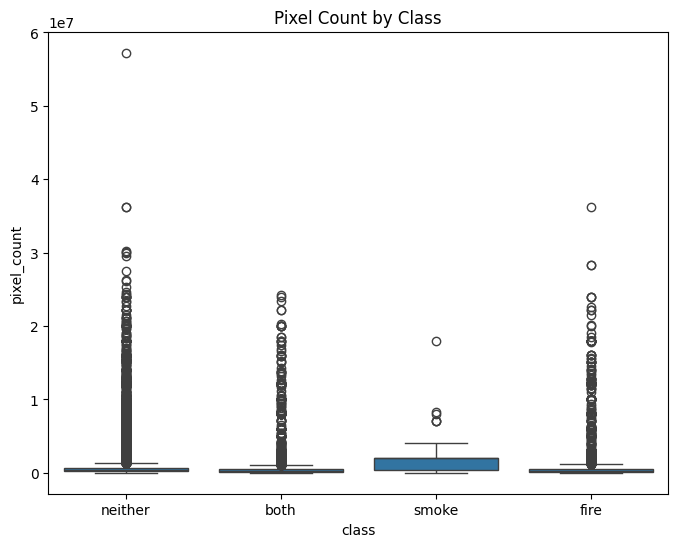

In [18]:
# pixel count boxplot by class
plt.figure(figsize=(8,6))
sns.boxplot(x='class', y='pixel_count', data=df)
plt.title('Pixel Count by Class')
plt.show()

### Confirm all images accessible

In [19]:
# ensure all image files can be opened
from PIL import Image
for idx, row in df.iterrows():
    try:
        img = Image.open(row['image_path'])
        img.verify()  # Verify that it is, in fact an image
    except (IOError, SyntaxError) as e:
        print(f"Bad file: {row['image_path']} - {e}")

No bad files!

### Create downsample for initial runthroughs

In [24]:
# Create downsample of the dataset for quicker experimentation
df_sample = df.sample(frac=0.1, random_state=42)
print(f"Downsampled dataset shape: {df_sample.shape}")

# look at class distribution in downsample
print(df_sample['class'].value_counts())

Downsampled dataset shape: (9531, 6)
class
neither    3963
smoke      2361
both       1965
fire       1242
Name: count, dtype: int64


In [25]:
df_sample.head()

,image_path,width,height,class,aspect_ratio,pixel_count
67063,images/neitherFireNorSmoke_CV022026.jpg,690,714,neither,0.966387,492660
8257,images/neitherFireNorSmoke_CV004700.jpg,325,450,neither,0.722222,146250
28494,images/bothFireAndSmoke_CV014234.jpg,512,384,both,1.333333,196608
21317,images/neitherFireNorSmoke_CV028776.jpg,524,650,neither,0.806154,340600
40587,images/neitherFireNorSmoke_CV007468.jpg,800,533,neither,1.500938,426400


In [26]:
df_sample.to_csv('image_data_sample.csv', index=False)

### Export data

In [27]:
df.to_csv('image_data_full.csv', index=False)